### Setup

In [1]:
from functools import reduce
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('summary.csv', index_col='file-name')
cmds = pd.read_csv('list-of-commands.txt', header=None).squeeze()
cmds.index = cmds.str.split().str[1]  # grab filename, set as index

### Check missing/failed runs

In [3]:
missingFiles = cmds.index.difference(data.index)
print('Missing/failed runs:', len(missingFiles))

Missing/failed runs: 47


### Check miscalibrated runs

In [4]:
whrBadCalib = data['quality-goodCalibration'] == 0
miscalibFiles = data[whrBadCalib].index
print('Miscalibrated files:', len(miscalibFiles))

Miscalibrated files: 3491


#### Impute miscalibrated params using other good runs

In [5]:
calibParamCols = [
    'calibration-xOffset(g)',
    'calibration-yOffset(g)',
    'calibration-zOffset(g)',
    'calibration-xSlope',
    'calibration-ySlope',
    'calibration-zSlope',
    'calibration-xSlopeTemp',
    'calibration-ySlopeTemp',
    'calibration-zSlopeTemp',
]

data.loc[whrBadCalib, calibParamCols] = np.nan

data[calibParamCols] = (
    data
    .groupby('file-deviceID')
    [calibParamCols]
    .transform(lambda x: x.fillna(x.mean()))
)

print('Files that cannot be calibrated:', data[calibParamCols].isna().any(1).sum())

Files that cannot be calibrated: 10


In [6]:
# files to be recalibrated
def reduce_join(df, columns, sep=" "):
    slist = [df[x].astype(str) for x in columns]
    return reduce(lambda x, y: x + sep + y, slist[1:], slist[0])

calibParams = data.loc[whrBadCalib, calibParamCols].dropna()
calibFiles = calibParams.index
calibParams = (
    " --calOffset " + reduce_join(calibParams, ['calibration-xOffset(g)', 'calibration-yOffset(g)', 'calibration-zOffset(g)'])
    + " --calSlope " + reduce_join(calibParams, ['calibration-xSlope', 'calibration-ySlope', 'calibration-zSlope'])
    + " --calTemp " + reduce_join(calibParams, ['calibration-xSlopeTemp', 'calibration-ySlopeTemp', 'calibration-zSlopeTemp'])
)

### Generate list of re-run commands

In [7]:
rerunFiles = missingFiles.union(calibFiles)
rerunCmds = cmds[rerunFiles]
rerunCmds.loc[calibFiles] += calibParams

with open('list-of-commands-rerun.txt', 'w') as f:
    f.write('\n'.join(rerunCmds.to_list()))

# now process with bash -c list-of-commands-rerun.txt

### Merge results from re-runs

In [8]:
# load rerun results
dataRerun = pd.read_csv('summary-reruns.csv', index_col='file-name')
data = data.drop(dataRerun.index).append(dataRerun)

### Check for outliers

array([[<AxesSubplot:title={'center':'acc-overall-avg'}>,
        <AxesSubplot:title={'center':'acc-overall-sd'}>,
        <AxesSubplot:title={'center':'wearTime-overall(days)'}>],
       [<AxesSubplot:title={'center':'calibration-errsAfter(mg)'}>,
        <AxesSubplot:title={'center':'errs-interrupts-num'}>,
        <AxesSubplot:title={'center':'errs-interrupt-mins'}>],
       [<AxesSubplot:title={'center':'clipsAfterCalibration'}>,
        <AxesSubplot:title={'center':'clipsBeforeCalibration'}>,
        <AxesSubplot:>]], dtype=object)

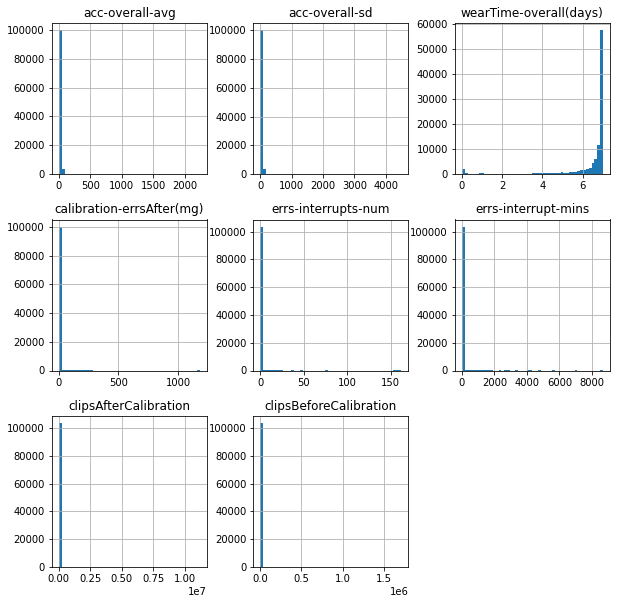

In [9]:
# check for outliers
data[[
    'acc-overall-avg',
    'acc-overall-sd',
    'wearTime-overall(days)',
    'calibration-errsAfter(mg)',
    'errs-interrupts-num',
    'errs-interrupt-mins',
    'clipsAfterCalibration',
    'clipsBeforeCalibration',
]].hist(bins=50, figsize=(10, 10))

array([[<AxesSubplot:title={'center':'calibration-xOffset(g)'}>,
        <AxesSubplot:title={'center':'calibration-yOffset(g)'}>,
        <AxesSubplot:title={'center':'calibration-zOffset(g)'}>],
       [<AxesSubplot:title={'center':'calibration-xSlope'}>,
        <AxesSubplot:title={'center':'calibration-ySlope'}>,
        <AxesSubplot:title={'center':'calibration-zSlope'}>],
       [<AxesSubplot:title={'center':'calibration-xSlopeTemp'}>,
        <AxesSubplot:title={'center':'calibration-ySlopeTemp'}>,
        <AxesSubplot:title={'center':'calibration-zSlopeTemp'}>]],
      dtype=object)

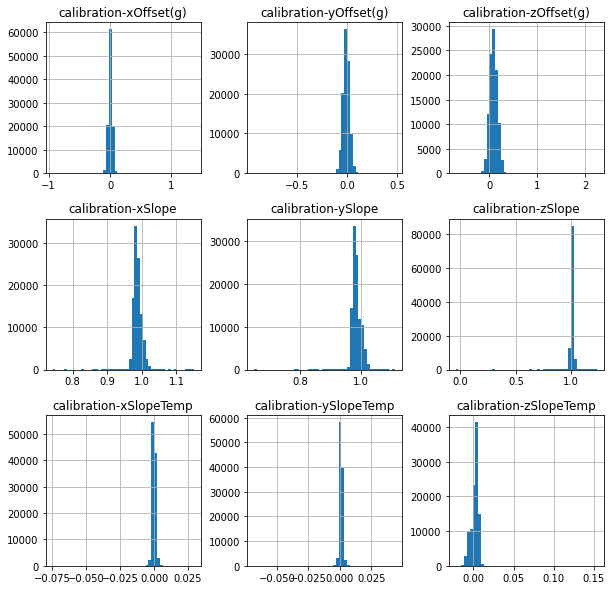

In [10]:
# check for outliers -- calib params
data[[
    'calibration-xOffset(g)',
    'calibration-yOffset(g)',
    'calibration-zOffset(g)',
    'calibration-xSlope',
    'calibration-ySlope',
    'calibration-zSlope',
    'calibration-xSlopeTemp',
    'calibration-ySlopeTemp',
    'calibration-zSlopeTemp',
]].hist(bins=50, figsize=(10, 10))